In [3]:
import os
import sys
import pickle
import warnings
import time
import logging
import glob


import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit


from utils import *


import seaborn as sns
from matplotlib import rcParams
from cycler import cycler


## Set plotting style and print options
sns.set_theme()
sns.set_style("darkgrid")
sns.set_context("paper") #Possible are paper, notebook, talk and poster

d = {'lines.linewidth': 2, 'axes.titlesize': 20, 'axes.titleweight': 'bold', 'axes.labelsize': 18, 'xtick.labelsize': 12, 'axes.labelweight': 'bold', 'ytick.labelsize': 12,\
     'legend.fontsize': 14, 'font.family': 'serif', 'font.weight': 'bold', 'figure.titlesize': 20,'figure.titleweight': 'bold',\
          'figure.labelsize': 18,'figure.labelweight': 'bold', 'figure.figsize': (9,6), }
d_colors = {'axes.prop_cycle': cycler(color = ['teal', 'navy', 'coral', 'plum', 'purple', 'olivedrab',\
         'black', 'red', 'cyan', 'brown', 'green', 'yellow', 'khaki','lightblue'])}
rcParams.update(d)
rcParams.update(d_colors)
np.set_printoptions(precision = 5, suppress=1e-10)

In [4]:

class AnalyseDefectsAll:
    def __init__(self, system_size_list, ):
        self.LX = system_size_list
        self.inputs_paths = [f"data\\nematic_analysis{LX}_LL0.05\\merged_results" for LX in self.LX]
        self.act_list = [list(np.load(os.path.join(path, "activity_list.npy"))) for path in self.inputs_paths]
        self.window_sizes = [list(np.load(os.path.join(path, 'window_sizes.npy'))) for path in self.inputs_paths]
        self.Nactivity = [len(act) for act in self.act_list]

        self.output_path = "data\\nematic_analysis_all"

    def get_av_defects(self, LX = 512, act_idx_bounds = None, density = True):

        idx = self.LX.index(LX)
        inputs_path = self.inputs_paths[idx]

        if act_idx_bounds is None:
            act_idx_bounds = [0, None]
        else:
            act_idx_bounds[0] = self.act_list[i].index(act_idx_bounds[0])
            act_idx_bounds[1] = self.act_list[i].index(act_idx_bounds[1]) + 1

        act_list = list(np.load(os.path.join(inputs_path, "activity_list.npy")))[act_idx_bounds[0]:act_idx_bounds[1]]

        norm = LX**2 if density else 1

        try:
            av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
        except:
            print('Average defects not found. Analyse defects first.')
            return

        return act_list, av_defects[act_idx_bounds[0]:act_idx_bounds[1]]

    def plot_av_defects(self, fit_dict = {}, LX_list = None, act_bounds = None, plot_density = True, verbose = False, inset_box=None):
        """
        fit_dict: dictionary containing the fit parameters with keys
        'fit_func': fit function
        'fit_string': string of the fit function
        'param_guess': guess for the fit parameters
        """
 
        if fit_dict == {}:
            do_fit = False
        else:
            do_fit = True
            fit_func = fit_dict['fit_func']
            fit_string = fit_dict['fit_string']
            param_guess = fit_dict['param_guess']

        fig, ax = plt.subplots(figsize=(9, 6))
        axin = ax.inset_axes(inset_box) if inset_box is not None else None
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list

        for i, LX in enumerate(self.LX):
            norm = LX**2 if plot_density else 1

            try:
                av_defects = np.load(os.path.join(self.inputs_paths[i], 'av_defects.npy')) / norm
            except:
                print('Average defects not found. Analyse defects first.')
                return
   
            ax.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i],\
                         label = f'L = {self.LX[i]}', alpha=.6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}' )
            if axin is not None:
                axin.errorbar(self.act_list[i], av_defects[:, 0], yerr = av_defects[:, 1], fmt = marker_shape[i], \
                               elinewidth=1.5, capsize=1.5, alpha=.6, capthick=1, markersize = 4, color = f'C{i}')

            if do_fit:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = self.act_list[i].index(act_bounds[0])
                    act_idx_bounds[1] = self.act_list[i].index(act_bounds[1]) + 1
     
                activities = np.array(self.act_list[i][act_idx_bounds[0]:act_idx_bounds[1]])
            
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=np.VisibleDeprecationWarning)

                    fit = do_chi2_fit(fit_func, activities, av_defects[act_idx_bounds[0]:act_idx_bounds[1], 0], \
                                av_defects[act_idx_bounds[0]:act_idx_bounds[1], 1]*10, parameter_guesses = param_guess, verbose=verbose)
                    Ndof, chi2, pval = get_statistics_from_fit(fit, len(activities), subtract_1dof_for_binning = False)

                  
                    print(f'For LX = {LX}:')
                    print("Valid minimum: ", fit.fmin.is_valid)
                    print('Params: ', fit.values[:])
                    print(f'Ndof = {Ndof}, chi2 = {chi2:.3f}, pval = {pval:.3f}\n')
                    
                #  d = generate_dictionary(fit, len(activities), chi2_suffix = None)
                #  text = nice_string_output(d, extra_spacing=4, decimals=3)
                #  add_text_to_ax(0.02, 0.96, text, ax, fontsize=14)

                ax.plot(activities, fit_func(activities, *fit.values[:]), '-', color = f'C{i}', label=rf'Fit $L = {LX}$', linewidth = 2)
        
        if do_fit:
            ax.text(0.10, 0.95, rf'Fit = {fit_string}', transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')

        ax.legend(loc='lower right')
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(r'$\langle \rho \rangle$')
        ax.set_title('Average defect density vs. activity')    
        fig.tight_layout()

        if axin is None:
            return fig, ax
        else:
           # ax.indicate_inset_zoom(axin)
            return fig, ax, axin
    
    def plot_alpha_mean(self, use_density_fit = False, act_bounds = None):
        
        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        for i, LX in enumerate(self.LX):
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
            
            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[i], label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4)

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax


    def plot_alpha_mean2(self, use_density_fit = False, include_fluc=True, include_sfac = True, include_unweighted = True, act_bounds = None):
        

        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']

        for i, LX in enumerate(self.LX):
            if include_fluc:
                try:
                    alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                    act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
                except:
                    print('Alpha list not found. Analyse hyperuniformity first.')
                    return
            if include_sfac:
                try:
                    alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av.npy'))
                    act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
                    if include_unweighted:
                        alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av_unweighted.npy'))
                except:
                    print('Alpha list not found. Analyse sfac first.')
                    return
                 

            if include_fluc:
                act_idx_bounds = [0, None]
                if act_bounds is None:
                    act_idx_bounds[0] = 0
                    act_idx_bounds[1] = None
                else:
                    act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                    act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
                
                act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
                alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

                ax.errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                            label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            if include_sfac:
                ax.errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[1], \
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            if include_unweighted:
                ax.errorbar(act_list_sfac, alpha_list_unweighted[:, 0], alpha_list_unweighted[:, 2], fmt = marker_shape[2], \
                             alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')

        ax.legend()
        ax.set_xlabel(r'$\zeta$')
        ax.set_ylabel(rf'$\langle\alpha \rangle$')
        ax.set_title(rf'Time av. of $\alpha $ vs activity')

        fig.tight_layout()
        return fig, ax

    
    def plot_alpha_mean_all(self, use_density_fit = False, act_bounds = None):
        

        suffix = 'dens' if use_density_fit else 'count'

        fig, ax = plt.subplots(ncols = 3, figsize=(16, 9))
        ax = ax.flatten()
        marker_shape = ['s-', 'o-', '^-', 'v-', 'D-', 'P-', 'X-', 'h-', 'd-', 'p-', 'H-', '8-', '1-', '2-']
        labels = [rf'$\langle \delta \rho ^2 \rangle$', rf'$S_W(k)$', rf'$S_U(k)$']
        for i, LX in enumerate(self.LX):
      
            try:
                alpha_list = np.load(os.path.join(self.inputs_paths[i], f'alpha_list_{suffix}.npy'))
                act_list = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit.npy')))
            except:
                print('Alpha list not found. Analyse hyperuniformity first.')
                return
        
            try:
                alpha_list_sfac = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av.npy'))
                act_list_sfac = list(np.load(os.path.join(self.inputs_paths[i], f'act_list_alpha_fit_sfac.npy')))
                alpha_list_unweighted = np.load(os.path.join(self.inputs_paths[i], f'fit_params_sfac_time_av_unweighted.npy'))
            except:
                print('Alpha list not found. Analyse sfac first.')
                return
                 

            act_idx_bounds = [0, None]
            if act_bounds is None:
                act_idx_bounds[0] = 0
                act_idx_bounds[1] = None
            else:
                act_idx_bounds[0] = act_list.index(max(act_bounds[0], act_list[0]))
                act_idx_bounds[1] = act_list.index(min(act_bounds[1], act_list[-2])) + 1
            
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            alpha_list = alpha_list[act_idx_bounds[0]:act_idx_bounds[1]]

            label = f'L = {self.LX[i]}' if i == 0 else None

            ax[0].errorbar(act_list, alpha_list[:, 0], alpha_list[:, 1], fmt = marker_shape[0], \
                        label = f'L = {self.LX[i]}', alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
            ax[1].errorbar(act_list_sfac, alpha_list_sfac[:, 0], alpha_list_sfac[:, 2], fmt = marker_shape[1], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
            ax[2].errorbar(act_list_sfac, alpha_list_unweighted[:, 0], alpha_list_unweighted[:, 2], fmt = marker_shape[2], \
                            alpha = .6, elinewidth=1.5, capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
            
        for i, label in enumerate(labels):  
            #ax[i].set_title(rf'Est. from {label}', fontsize=16)
            ax[i].text(0.50, 0.97, rf'Est. from {label}', transform=ax[i].transAxes, fontsize=16, verticalalignment='top')
      
       # ax[0].title.set_text(rf'Estimated $\alpha$ from density fluctuations')
       # ax[1].title.set_text(rf'Estimated $\alpha$ from structure factor')
       # ax[2].title.set_text(rf'Estimated $\alpha$ from structure factor (unweighted)')
        
        fig.supxlabel(rf'$\zeta$')
        fig.supylabel(rf'$\langle\alpha \rangle$')
        fig.suptitle(rf'Time av. of $\alpha $ vs activity', y = 1.018)
        fig.tight_layout()
        return fig, ax


    def plot_susceptibility(self, act_max_list = [], window_idx_bounds_list = None, \
                            act_bounds = None, verbose = False, save = False):

        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        for i, LX in enumerate(self.LX):
            try:
                xi = np.load(os.path.join(self.inputs_paths[i], 'susceptibility.npy'))
            except:
                print('Susceptibilities not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]
            window_sizes = self.window_sizes[i]

            if window_idx_bounds_list is None:
                window_idx_bounds = [0, len(window_sizes)]
            else:
                window_idx_bounds = window_idx_bounds_list[i]
            if act_bounds is None:
                act_idx_bounds = [0, len(act_list)]
            else:
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            window_sizes = window_sizes[window_idx_bounds[0]:window_idx_bounds[1]]
            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            xi = xi[window_idx_bounds[0]:window_idx_bounds[1], act_idx_bounds[0]:act_idx_bounds[1], :]

            bin_count = np.bincount(np.argmax(xi[:, :, 0], axis = -1))
            if verbose:
                try:
                    for k, act in enumerate(act_list):
                        if bin_count[k] > 0:
                            print("No. of windows with max susceptibility at activity {:.3f}: {:.0f}".format(act, bin_count[k]))
                except:
                    pass

            act_max = act_list[np.argmax(bin_count)] if len(act_max_list) == 0 else act_max_list[i]
            act_max_idx = act_list.index(act_max)
            xi_normed = np.zeros((len(window_sizes), len(act_list), 2))
    
            with warnings.catch_warnings():
                warnings.simplefilter("ignore", category=RuntimeWarning)
                for j, window in enumerate(window_sizes):
                    norm = xi[j, act_max_idx, 0]
                    xi_normed[j, :, 0] = xi[j, :, 0] / norm
                    xi_normed[j, :, 1] = xi[j, :, 1] / norm
        
                xi_mean = np.nanmean(xi_normed[:,:,0], axis = 0)
                xi_std = np.nanstd(xi_normed[:,:,1], axis = 0) / np.sqrt(len(window_sizes))

            ax.errorbar(act_list, xi_mean, xi_std, label=f'L = {self.LX[i]}', fmt='.-', \
                            capsize=2, capthick=1, elinewidth=1, markeredgewidth=2, alpha = 1, markersize=4, color=f'C{i}') 
            
        ax.legend(loc='lower right', ncol=2)
        ax.set_xlabel(rf'$\zeta$ (activity)')
        ax.set_ylabel(r'$\chi  / \chi_{max}$')


        fig.suptitle(rf'Susceptibility of defect density vs activity', fontsize=20)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, 'susceptibility.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    def plot_binder_cumulants(self, act_bounds_list = None, LX_list = None, normalize = False, plot_binder = False, save = False):
            
        fig, ax = plt.subplots(figsize=(9, 6))
        marker_shape = ['s', 'o', '^', 'v', 'D', 'P', 'X', 'h', 'd', 'p', 'H', '8', '1', '2']

        LX_list = self.LX if LX_list is None else LX_list
        for i, LX in enumerate(LX_list):
            try:
                binder = np.load(os.path.join(self.inputs_paths[i], 'binder_cumulants.npy'))
            except:
                print('Binder cumulants not found. Analyse defects first.')
                return
            
            act_list = self.act_list[i]

            if act_bounds_list is None:
                act_idx_bounds = [0, len(act_list)]
                act_bounds = [act_list[0], act_list[-2]]
            else:
                act_bounds = act_bounds_list[i]
                act_idx_bounds = [act_list.index(max(act_bounds[0], act_list[0])), act_list.index(min(act_bounds[1], act_list[-2])) + 1]

            act_list = act_list[act_idx_bounds[0]:act_idx_bounds[1]]
            binder = binder[act_idx_bounds[0]:act_idx_bounds[1], :]

            if normalize:
                if plot_binder:
                    max_val = np.max(np.abs(binder[:, 0]))
                else:
                    max_val = np.max(2/3 - binder[:, 0])
                title_suffix = '(normalized)'
            else:
                max_val = 1
                title_suffix = ''
                
            if plot_binder:
                y = binder[:, 0]

                ylabel = rf'$U_B(\rho)$ {title_suffix}'
                title = rf'Binder cumulants of $\rho$ vs activity'
                label=r'$U_B(\rho) = 1 - \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'lower right'
            else:
                y = 2/3 - binder[:, 0]
                ylabel = rf'$U(\rho)$ {title_suffix}'
                title = rf'Cumulants of $\rho$ vs activity'
                label=r'$U(\rho) = \frac{\langle \rho^4 \rangle}{3 \langle \rho^2 \rangle ^2} - \frac{1}{3}$'
                ax.text(0.7, 0.8, label, transform=ax.transAxes, fontsize=16, verticalalignment='top', fontweight='bold')
                loc = 'upper right'

            ax.errorbar(act_list, y / max_val, binder[:, 1] / max_val, fmt = f'.-', label = f'L = {LX}', elinewidth=1.5, \
                        capsize=1.5, capthick=1, markersize = 4, color = f'C{i}')
        
        ax.legend(loc=loc, ncol=2)
        ax.set_xlabel(r' $\zeta$')
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        fig.tight_layout()

        if save:
            fig.savefig(os.path.join(self.output_path, f'binder_cumulants{title_suffix}.png'), dpi = 420, pad_inches=0.25)
        return fig, ax

    


In [5]:
system_size_list = [256, 512, 1024, 2048]
ada = AnalyseDefectsAll(system_size_list)


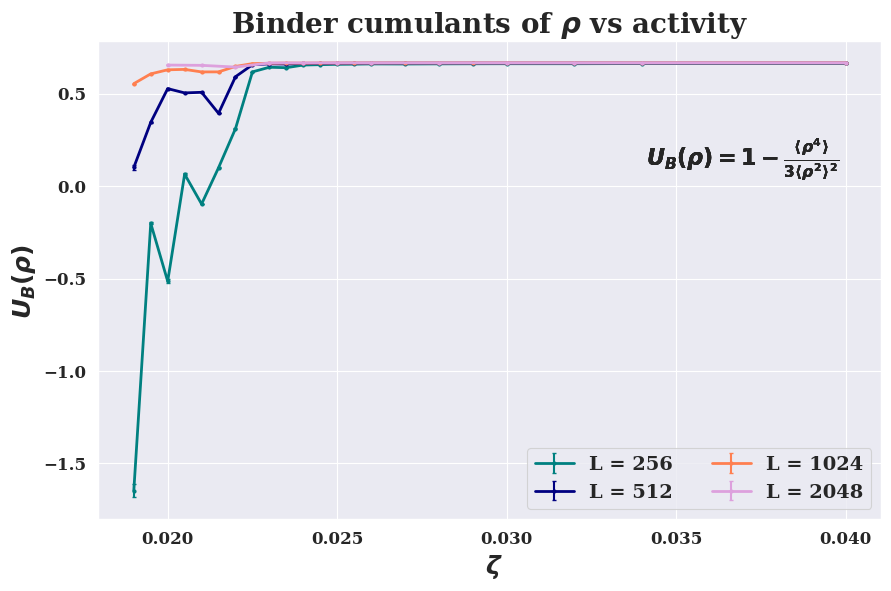

In [8]:
act_bounds = [0.019, 0.04]
act_bounds_list = [act_bounds] * len(system_size_list)
ada.plot_binder_cumulants(act_bounds_list=act_bounds_list, LX_list=[256,512,1024, 2048],\
                           normalize = False, plot_binder=True, save = True);

In [ ]:
window_idx_bounds_list = [[7, None], [0, None], [0, None],  [0, None]]
act_max_list = [0.022, 0.0215, 0.0215, 0.022]    
fig, ax = ada.plot_susceptibility(act_bounds = [0.015, .1], \
            window_idx_bounds_list = window_idx_bounds_list, act_max_list=act_max_list, save = True)
ax.set_ylim(0, 1.1)
ax.set_xlim(0.015, .06)
fig.savefig(os.path.join(ada.output_path, 'susceptibility_zoom.png'), dpi = 420, pad_inches=0.25)

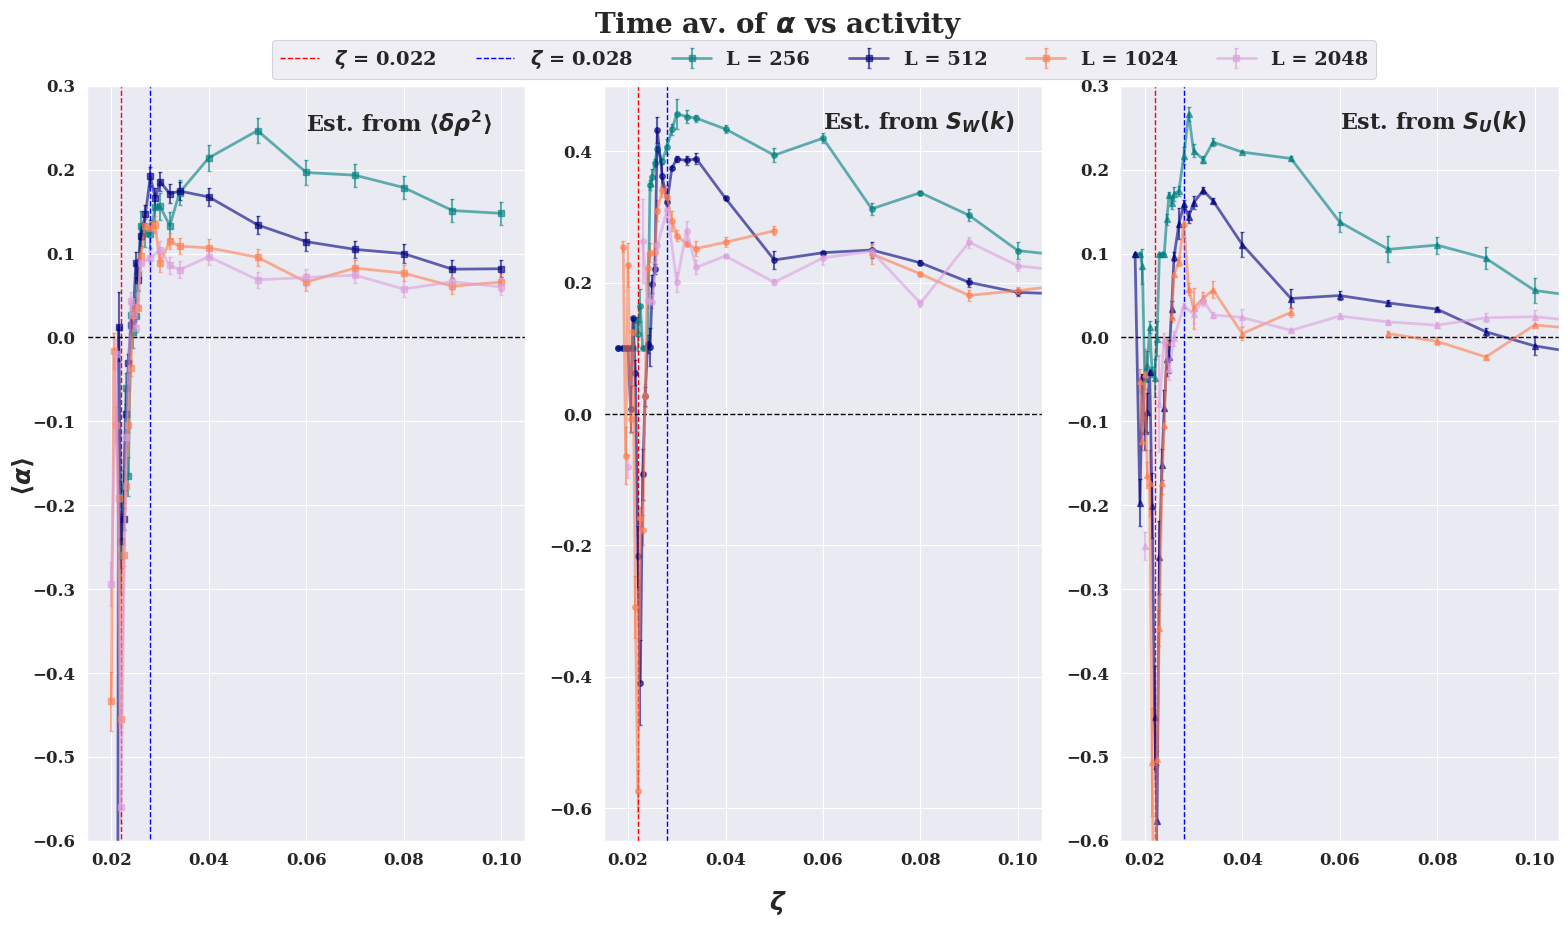

In [598]:
fig, ax = ada.plot_alpha_mean_all(use_density_fit=True, act_bounds = [0.02, 0.1], );
for i, axx in enumerate(ax):
    if i == 1:
        axx.set_ylim(-.65, .5)
        
    elif i == 0:
        axx.set_ylim(-.6, .3)
    else:
        axx.set_ylim(-.6, .3)
    label1 = r'$\zeta$ = 0.022' if i == 0 else None
    label2 = r'$\zeta$ = 0.028' if i == 0 else None
    axx.vlines(0.022, -.65, .5, color = 'red', linewidth = 1, linestyle = '--', label = label1)
    axx.vlines(0.028, -.65, .5, color = 'blue', linewidth = 1, linestyle = '--', label = label2)
    axx.set_xlim(0.015, .105)
    axx.hlines(0, 0, .105, color = 'black', linewidth = 1, linestyle = '--')
fig.legend(ncol=8, fontsize = 14, bbox_to_anchor=(0.88, .995))
#ax.set_ylim(-.6, .5)
#ax.set_xlim(0.015, .1)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.015, 0.1)

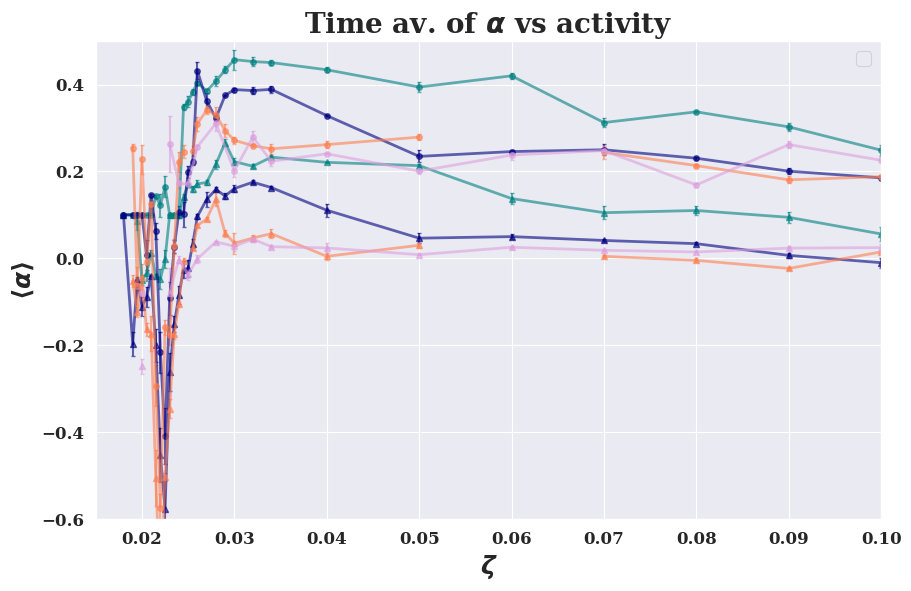

In [464]:
fig, ax = ada.plot_alpha_mean(use_density_fit=True, act_bounds = [0.02, 0.1], include_fluc=False, include_sfac=True, include_unweighted=True
                               );
ax.set_ylim(-.6, .5)
ax.set_xlim(0.015, .1)

In [601]:
def log_func(x, a, b, c):
    return a * np.log(np.abs(x * b)) + c
def linear(x, a, b):
    return a * x ** 0.5 + b

def power(x, a, b, c):
    return a * x ** b + c
def logistic_func(x, a, b, c, d, e, f):
    val = a / (1 +  np.exp(-b * (x - c))) * ( d * np.log(x) + e * x + f)
    return val
def logistic_func(x, a, b, c):
    val = a / (1 +  np.exp(-b * (x - c))) 
    return val
# do a linear fit to the average defect density



fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} \cdot (d \ln x + ex + f)$'
fit_string_logistic = r'$y = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y = a \ln (x / b) + c $'
fit_string_lin = rf'$y = a x + b$'
fit_string_power = rf'$y = a x^b + c$'
param_guess_log = np.array([0.005, 500,0.001])
param_guess_lin = np.array([0.005, 0.04])
param_guess_power = np.array([0.005, 0.5,-0.005])
param_guess_logistic = np.array([0.002, 2000, 0.023,])

fit_func = linear
param_guess = param_guess_lin
fit_string = fit_string_lin

fit_func = logistic_func
param_guess = param_guess_logistic
fit_string = fit_string_logistic

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power

fit_func = log_func
param_guess = param_guess_log
fit_string = fit_string_log

fit_func = power
param_guess = param_guess_power
fit_string = fit_string_power


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 6, param_guess = param_guess)


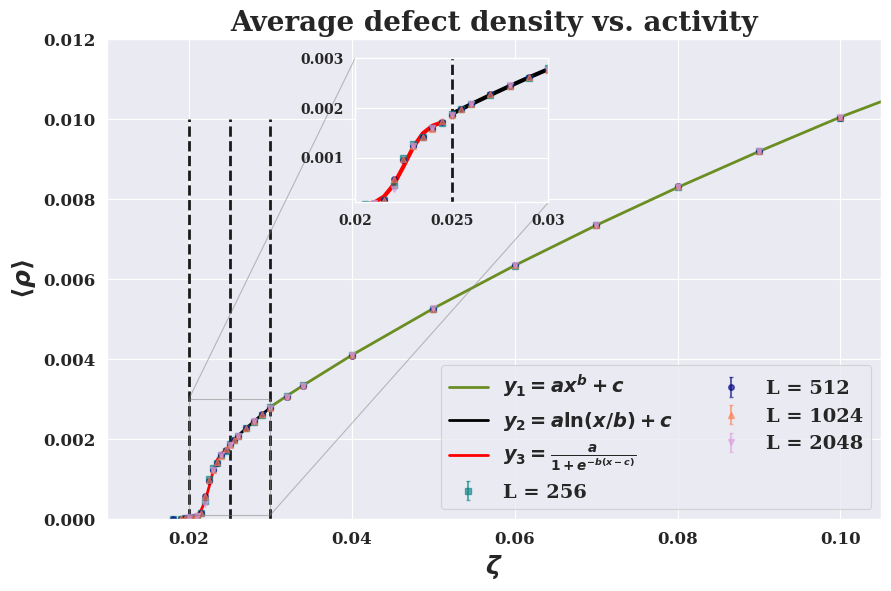

In [600]:

fig, ax, axin = ada.plot_av_defects(act_bounds=[0.021, 0.024], inset_box = [0.32, 0.66, 0.25, 0.3])

p_power = np.array([0.05563591932395208, 0.5925762989386102, -0.004164450175068781])
p_log = np.array([0.004958101922293866, 55.446575064673716, 0.00026152453890848973])
p_logistic = np.array([0.001622290610085664, 2324.4665041694207, 0.022408143634890017])
p_logistic = np.array([0.0017626217917815334, 1822.8633695130754, 0.02257778086582252])

#axin = ax.inset_axes([0.3, 0.64, 0.2, 0.25])
axin.set_xlim([0.02,0.03])
axin.set_ylim([0.0001, 0.003])
axin.set_xticks([0.02,0.025,0.03], [0.02,0.025,0.03], fontsize=10)
axin.set_yticks([0.001,0.002,0.003], [0.001,0.002,0.003], fontsize=10)

ax.indicate_inset_zoom(axin)

act_list = ada.act_list[0]
act_list_power = act_list[act_list.index(0.03):]
act_list_log = np.array(act_list[act_list.index(0.025):act_list.index(0.032)])
act_list_logistic = np.array(act_list[act_list.index(0.02):act_list.index(0.025)])


fit_string_logistic = r'$y_3 = \frac{{a}}{{1 + e^{{-b(x-c)}}}} $'
fit_string_log = rf'$y_2 = a \ln (x / b) + c $'
fit_string_power = rf'$y_1 = a x^b + c$'

ax.plot(act_list_power, power(act_list_power, *p_power), '-', label = fit_string_power, color=f'C5')
ax.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6')
ax.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7')

axin.plot(act_list_log, log_func(act_list_log, *p_log), '-', label = fit_string_log, color=f'C6', lw=3)
axin.plot(act_list_logistic, logistic_func(act_list_logistic, *p_logistic), '-', label = fit_string_logistic, color=f'C7', lw=3)

ax.set_xlim([0.01,0.105])
ax.set_ylim([0, 0.012])
ax.vlines(0.03, 0, 0.01, color = 'k', linestyle = '--')
ax.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
ax.vlines(0.02, 0, 0.01, color = 'k', linestyle = '--')
axin.vlines(0.025, 0, 0.01, color = 'k', linestyle = '--')
#axin.vlines(0.02225, 0, 0.01, color = 'g', linestyle = '--', lw=1)


#ax.set_ylim([0, .005])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend(ncol=2, loc='lower right')

For LX = 256:
Valid minimum:  True
Params:  [0.05543959686619293, 0.44841296155588317, -0.008715974342167193]
Ndof = 4, chi2 = 0.433, pval = 0.980

For LX = 512:
Valid minimum:  True
Params:  [0.049412793931467296, 0.3353527775038852, -0.01245705446162386]
Ndof = 4, chi2 = 5.836, pval = 0.212

For LX = 1024:
Valid minimum:  True
Params:  [0.055891239419096676, 0.44995894044036294, -0.008746731759455513]
Ndof = 4, chi2 = 21.547, pval = 0.000

For LX = 2048:
Valid minimum:  False
Params:  [0.05033089142901452, 0.3579404103430424, -0.011562910421947067]
Ndof = 1, chi2 = 63.645, pval = 0.000



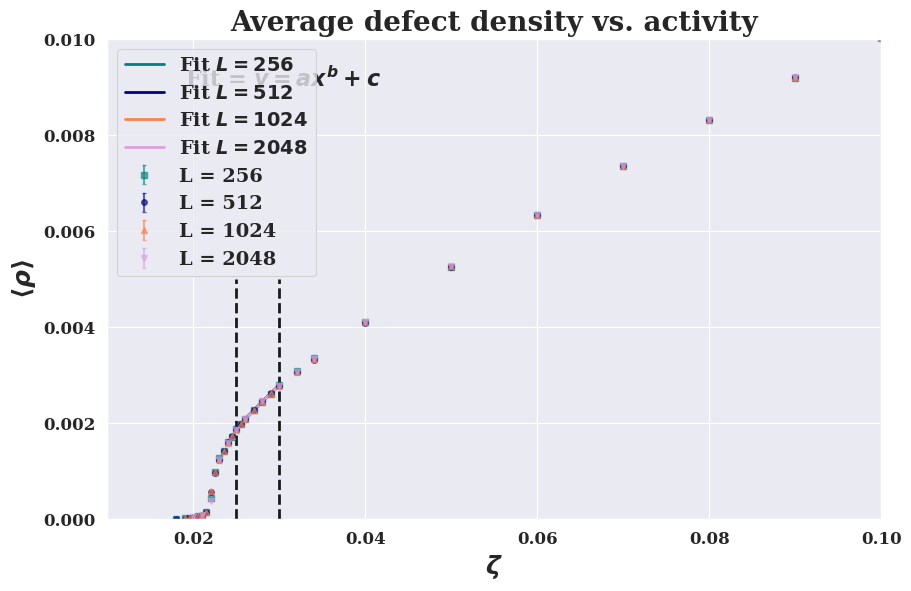

In [607]:


fit_dict = dict(fit_func = fit_func, fit_string = fit_string, lower_act_index = 6, param_guess = param_guess)

fig, ax = ada.plot_av_defects(fit_dict=fit_dict,act_bounds=[0.025, 0.03], LX_list=[256,512,1024])
ax.set_xlim([0.01,0.1])
ax.vlines(0.03, 0, 0.005, color = 'k', linestyle = '--')
ax.vlines(0.025, 0, 0.005, color = 'k', linestyle = '--')
ax.set_ylim([0, .01])
#ax.set_yscale('log', base=10)
#ax.set_xscale('log')
ax.legend() #loc='lower right')